# Conditional Expectation Regression with NCP (1D -> 1D)

This notebook trains a small Neural Conditional Probability (NCP) model on a 1D->1D toy dataset where the conditional distribution is:
- Unimodal and noisy for |x| <= 1 (expectation is meaningful and near the mode).
- Bimodal for 1 < |x| <= 2 (two symmetric modes; expectation is close to the middle with low probability).

We evaluate how well NCP learns a representation that supports accurate conditional expectation regression.

In [1]:
%load_ext autoreload
%autoreload 2

import math
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import torch
from symm_learning.models import MLP
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from symm_rep_learn.models.neural_conditional_probability.ncp import NCP

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
plt.style.use("seaborn-v0_8-notebook")
FIG_SIZE = (3, 2)

# Paths
ROOT = pathlib.Path(os.getcwd())
PLOT_PATH = ROOT / "plots"
PLOT_PATH.mkdir(parents=True, exist_ok=True)
CHECKPOINT_PATH = ROOT / "checkpoints"
CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)

print(f"Using device: {DEVICE}")
print(f"Checkpoint directory: {CHECKPOINT_PATH}")

EMBEDDING_DIM = 32
BATCH_SIZE = 2024

Using device: cuda
Checkpoint directory: /home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_expectation_regression/checkpoints


## Plotting utilities file (plotting.py)
We will use helper functions from `plotting.py` in this folder.

In [2]:
import sys

sys.path.append(os.getcwd())
from plotting import (
    LiveLossPlotter,
    plot_conditional_cdf_on_support,
    plot_expectations_with_quantiles,
    scatter_with_density,
)

In [3]:
# Checkpoint utility functions
def save_checkpoint(model, optimizer, best_val_loss, epoch, checkpoint_path):
    """Save model checkpoint"""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'epoch': epoch,
        'seed': SEED,
        'embedding_dim': EMBEDDING_DIM,
        'batch_size': BATCH_SIZE
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")

def load_checkpoint(model, optimizer, checkpoint_path):
    """Load model checkpoint if it exists"""
    if checkpoint_path.exists():
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer is not None:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['best_val_loss'], checkpoint['epoch']
    return None, None

def checkpoint_exists(checkpoint_path):
    """Check if checkpoint exists"""
    return checkpoint_path.exists()

In [4]:
# Checkpoint management utilities
def list_checkpoints():
    """List all available checkpoints"""
    checkpoints = list(CHECKPOINT_PATH.glob("*.pth"))
    if checkpoints:
        print("Available checkpoints:")
        for ckpt in checkpoints:
            size = ckpt.stat().st_size / (1024 * 1024)  # MB
            print(f"  - {ckpt.name} ({size:.1f} MB)")
    else:
        print("No checkpoints found")
    return checkpoints

def clear_checkpoints():
    """Remove all checkpoints (use with caution!)"""
    checkpoints = list(CHECKPOINT_PATH.glob("*.pth"))
    for ckpt in checkpoints:
        ckpt.unlink()
        print(f"Removed {ckpt.name}")
    print(f"Cleared {len(checkpoints)} checkpoints")

def clear_specific_checkpoint(model_name):
    """Remove specific model checkpoint"""
    checkpoint_file = CHECKPOINT_PATH / f"{model_name}.pth"
    if checkpoint_file.exists():
        checkpoint_file.unlink()
        print(f"Removed {checkpoint_file.name}")
    else:
        print(f"Checkpoint {checkpoint_file.name} not found")

# Show current checkpoint status
print("Current checkpoint status:")
list_checkpoints()
print(f"\nTo clear all checkpoints, run: clear_checkpoints()")
print(f"To clear specific checkpoint, run: clear_specific_checkpoint('model_name')")
print(f"Available models: 'baseline_mlp', 'ncp_model', 'encp_model'")

Current checkpoint status:
Available checkpoints:
  - encp_model.pth (4.4 MB)
  - baseline_mlp.pth (0.1 MB)

To clear all checkpoints, run: clear_checkpoints()
To clear specific checkpoint, run: clear_specific_checkpoint('model_name')
Available models: 'baseline_mlp', 'ncp_model', 'encp_model'


## Synthetic dataset: unimodal center, bimodal edges
- For |x| <= 1: y = f_c(x) + eps1 with eps1 ~ N(0, 0.05)
- For 1 < |x| <= 2: y = s * a(x) + eps2 with s in {-1, 1} equally likely,
  a(x) = 0.5 + 0.8*(|x|-1), eps2 ~ N(0, 0.03).
True conditional expectation: f_c(x) for |x|<=1 and 0 for 1<|x|<=2.

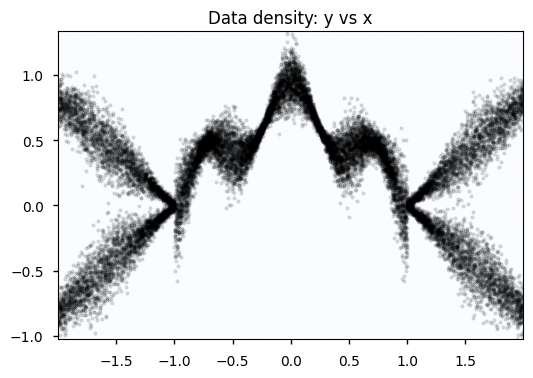

In [5]:
def f_center(x):
    return 0.5 * torch.cos(2 / 3 * math.pi * x) + 0.2 * torch.cos(4 * 2 / 3 * math.pi * x) + 0.25


def make_dataset(n=20000, seed=SEED, x=None):
    """Generate dataset (x, y). If x is provided, use it to condition the sampling.

    Args:
        n: number of samples to generate (ignored if x is an array with its own length)
        seed: RNG seed
        x: None (default, sample x ~ U[-2,2]); scalar (use a constant x for all samples);
           or array-like of shape (n,) or (n,1) providing the x's to use.
    """
    rng = np.random.default_rng(seed)

    # Build x according to the request
    if x is None:
        x_np = rng.uniform(-2.0, 2.0, size=(n, 1)).astype(np.float32)
    else:
        if np.isscalar(x):
            x_np = np.full((n, 1), float(x), dtype=np.float32)
        else:
            x_arr = np.asarray(x, dtype=np.float32)
            if x_arr.ndim == 1:
                x_arr = x_arr.reshape(-1, 1)
            assert x_arr.shape[1] == 1, f"x must be (n,) or (n,1), got {x_arr.shape}"
            # If provided x length disagrees with n, trust x's length
            if x_arr.shape[0] != n:
                n = x_arr.shape[0]
            x_np = x_arr

    x_t = torch.from_numpy(x_np)
    absx = torch.abs(x_t)

    # Heteroscedastic noise scales
    # Unimodal region |x|<=1: higher variance near |x|=1 and with oscillations
    sigma_uni = 0.02 + 0.06 * (absx**2) + 0.1 * torch.cos(2 * math.pi * x_t) ** 2
    # Bimodal region 1<|x|<=2: variance grows with distance from 1 and oscillates with |x|
    sigma_bi = 0.02 + 0.05 * (absx - 1.0).clamp(min=0) ** 2 + 0.1 * torch.sin(3 * absx) ** 2

    # Unimodal region |x|<=1
    eps1 = torch.randn_like(x_t) * sigma_uni
    y_uni = f_center(x_t) + eps1

    # Bimodal region 1<|x|<=2
    s = torch.from_numpy(rng.choice([-1.0, 1.0], size=(n, 1))).to(torch.float32)
    a = 0.8 * (absx - 1.0)
    eps2 = torch.randn_like(x_t) * sigma_bi
    y_bi = s * a + eps2

    y = torch.where(absx <= 1.0, y_uni, y_bi)
    return x_t, y


@torch.no_grad()
def true_condexp(x):
    x = torch.as_tensor(x, dtype=torch.float32)
    absx = torch.abs(x)
    y = torch.where(absx <= 1.0, f_center(x), torch.zeros_like(x))
    return y


# Generate full dataset
N = 20000
x, y = make_dataset(N)

# Quick preview plot
fig, ax = plt.subplots(figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1] * 2))
scatter_with_density(x.numpy(), y.numpy(), ax=ax)
ax.set_title("Data density: y vs x")
plt.show()

## Split, standardize, and create DataLoaders

In [6]:
# Train/val/test split
idx = torch.randperm(x.shape[0])
train_end = int(0.7 * len(idx))
val_end = int(0.85 * len(idx))
idx_tr, idx_val, idx_te = idx[:train_end], idx[train_end:val_end], idx[val_end:]

x_tr, y_tr = x[idx_tr], y[idx_tr]
x_val, y_val = x[idx_val], y[idx_val]
x_te, y_te = x[idx_te], y[idx_te]

# Standardize using train stats
x_mean, x_std = x_tr.mean(0, keepdim=True), x_tr.std(0, keepdim=True) + 1e-8
y_mean, y_std = y_tr.mean(0, keepdim=True), y_tr.std(0, keepdim=True) + 1e-8

x_tr_c = (x_tr - x_mean) / x_std
y_tr_c = (y_tr - y_mean) / y_std
x_val_c = (x_val - x_mean) / x_std
y_val_c = (y_val - y_mean) / y_std
x_te_c = (x_te - x_mean) / x_std
y_te_c = (y_te - y_mean) / y_std

train_dl = DataLoader(TensorDataset(x_tr_c, y_tr_c), batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(TensorDataset(x_val_c, y_val_c), batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(TensorDataset(x_te_c, y_te_c), batch_size=BATCH_SIZE, shuffle=False)

print("Standardization done.")

Standardization done.


## Baseline: MLP trained with MSE (same architecture and training config)

MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)
Loading baseline model from checkpoint...
Loading checkpoint from /home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_expectation_regression/checkpoints/baseline_mlp.pth
Baseline loaded - best val MSE: 0.55868


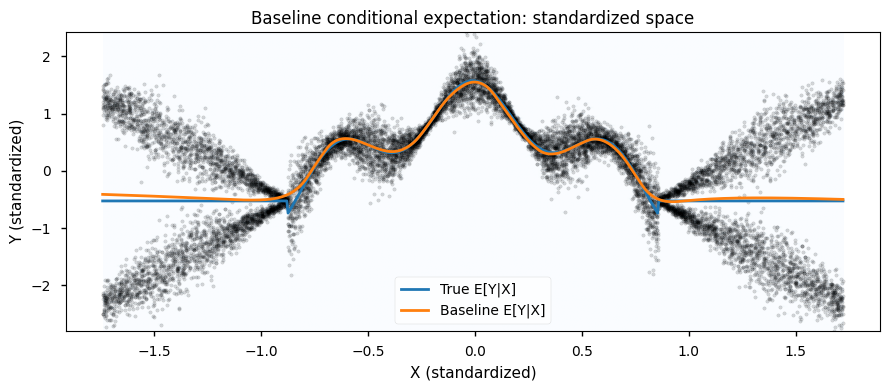

In [7]:
baseline_mlp = MLP(
    in_dim=1,
    out_dim=1,
    hidden_units=[EMBEDDING_DIM * 2] * 2 + [EMBEDDING_DIM] * 2,
    activation=torch.nn.ELU(),
    bias=True,
).to(DEVICE)
print(baseline_mlp)
opt_base = torch.optim.Adam(baseline_mlp.parameters(), lr=1e-3)

# Match training hyperparams between baseline and NCP
EPOCHS = 1000
CHECK_EVERY = 10
PATIENCE = 10
PLOT_FREQ = 50  # update live plot every N epochs

# Checkpoint path for baseline
baseline_checkpoint = CHECKPOINT_PATH / "baseline_mlp.pth"

@torch.no_grad()
def val_mse(model, dl):
    model.eval()
    tot, n = 0.0, 0
    for xb, yb in dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        tot += torch.mean((pred - yb) ** 2).item()
        n += 1
    return tot / max(1, n)

# Check if checkpoint exists
if checkpoint_exists(baseline_checkpoint):
    print("Loading baseline model from checkpoint...")
    best_val, last_epoch = load_checkpoint(baseline_mlp, opt_base, baseline_checkpoint)
    print(f"Baseline loaded - best val MSE: {best_val:.5f}")
else:
    print("Training baseline model from scratch...")
    best_val = float("inf")
    pat = 0
    best_baseline_state = baseline_mlp.state_dict()

    pbar = tqdm(range(EPOCHS), desc="Training Baseline MLP")
    plotter_base = LiveLossPlotter(title="Baseline: train/val loss (MSE)", plot_freq=PLOT_FREQ)
    for epoch in pbar:
        baseline_mlp.train()
        for xb, yb in train_dl:  # same BATCH_SIZE as defined earlier
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt_base.zero_grad()
            pred = baseline_mlp(xb)
            loss = torch.mean((pred - yb) ** 2)
            loss.backward()
            opt_base.step()

        if epoch % CHECK_EVERY == 0 or epoch == EPOCHS - 1:
            vm = val_mse(baseline_mlp, val_dl)
            pbar.set_postfix(train_loss=loss.item(), val_mse=vm)
            # live update at val check (forces redraw regardless of freq)
            plotter_base.update(epoch, train_loss=float(loss.item()), val_loss=float(vm), force=True)
            if vm < best_val:
                best_val = vm
                best_baseline_state = {k: v.cpu() for k, v in baseline_mlp.state_dict().items()}
                pat = 0
                # Save checkpoint when we get a better validation score
                save_checkpoint(baseline_mlp, opt_base, best_val, epoch, baseline_checkpoint)
            else:
                pat += 1
                if pat >= PATIENCE:
                    print(f"Early stopping baseline at epoch {epoch}")
                    break

    baseline_mlp.load_state_dict(best_baseline_state)
    plotter_base.close()
    print(f"Baseline best val MSE: {best_val:.5f}")


@torch.no_grad()
def baseline_predict(x_in):
    baseline_mlp.eval()
    return baseline_mlp(x_in.to(DEVICE)).cpu()


# Baseline-only conditional expectation plot (standardized space)
x_grid = torch.linspace(-2.0, 2.0, 600).reshape(-1, 1)
x_grid_c = (x_grid - x_mean) / x_std

with torch.no_grad():
    y_true_c = (true_condexp(x_grid) - y_mean) / y_std
    y_base_c = baseline_predict(x_grid_c)

# Use the plotting utility to render expectations (no quantiles here)
expectations_baseline = {
    "True E[Y|X]": y_true_c.numpy().ravel(),
    "Baseline E[Y|X]": y_base_c.numpy().ravel(),
}
fig, ax = plot_expectations_with_quantiles(
    x_train=x_tr_c.numpy().ravel(),
    y_train=y_tr_c.numpy().ravel(),
    x_grid=x_grid_c.numpy().ravel(),
    expectations=expectations_baseline,
    true_quantiles=None,
    est_quantiles=None,
    figsize=(FIG_SIZE[0] * 3, FIG_SIZE[1] * 2),
)
ax.set_title("Baseline conditional expectation: standardized space")
fig.tight_layout()
fig.savefig(PLOT_PATH / "baseline_condexp_full.png", dpi=200)
plt.show()

## NCP model (after baseline)

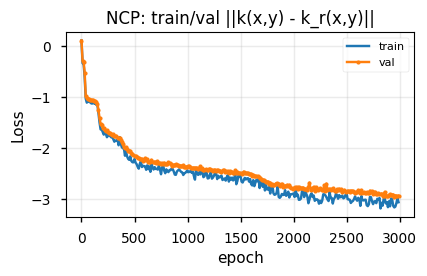

Training NCP: 100%|██████████| 3000/3000 [04:27<00:00, 11.22it/s, loss=-3.03, val=-2.9]


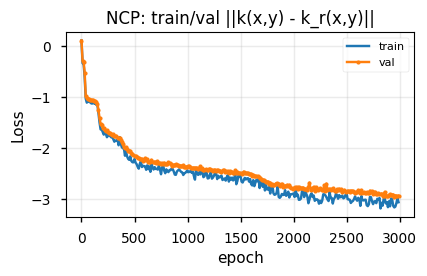

NCP best val objective: -2.92440
NCP model ready for inference


In [9]:
from symm_rep_learn.nn.layers import ResidualEncoder

BATCH_NORM = False
ORTH_REG = 0.01
CENTERING_REG = 0.00
MOMENTUM = 0.999
ncp = NCP(
    embedding_x=ResidualEncoder(
        MLP(
            in_dim=1,
            out_dim=EMBEDDING_DIM,
            hidden_units=[EMBEDDING_DIM * 2] * 2,
            activation=torch.nn.ELU(),
            bias=True,
            batch_norm=BATCH_NORM,
        ),
        in_dim=1,
    ),
    embedding_y=ResidualEncoder(
        MLP(
            in_dim=1,
            out_dim=EMBEDDING_DIM,
            hidden_units=[EMBEDDING_DIM * 2] * 2,
            activation=torch.nn.ELU(),
            bias=True,
            batch_norm=BATCH_NORM,
        ),
        in_dim=1,
    ),
    embedding_dim_x=EMBEDDING_DIM + 1,
    embedding_dim_y=EMBEDDING_DIM + 1,
    orth_reg=ORTH_REG,
    centering_reg=CENTERING_REG,
    momentum=MOMENTUM,
).to(DEVICE)

print(ncp)

# Train NCP with early stopping on validation negative loss (the lower, the better)
CHECK_EVERY = 10
PATIENCE = 50
NCP_LR = 1e-3
optimizer = torch.optim.Adam(ncp.parameters(), lr=NCP_LR)

# Checkpoint path for NCP
ncp_checkpoint = CHECKPOINT_PATH / "ncp_model.pth"

@torch.no_grad()
def val_objective(ncp_model, dl):
    metrics = {}
    ncp_model.eval()
    tot, n = 0.0, 0
    for xb, yb in dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        fx, hy = ncp_model(xb, yb)
        loss, batch_metrics = ncp_model.loss(fx, hy)
        tot += float(loss.item())
        n += 1

        # Update metrics with batch values
        for k, v in batch_metrics.items():
            if k in metrics:
                metrics[k].append(v)
            else:
                metrics[k] = [v]
    # Average the metrics across the batch
    for k, v in metrics.items():
        metrics[k] = np.mean(v)

    return tot / max(1, n), metrics

# Check if checkpoint exists
if checkpoint_exists(ncp_checkpoint):
    print("Loading NCP model from checkpoint...")
    best_val, last_epoch = load_checkpoint(ncp, optimizer, ncp_checkpoint)
    print(f"NCP loaded - best val objective: {best_val:.5f}")
else:
    print("Training NCP model from scratch...")
    best_val = float("inf")
    pat = 0
    best_ncp_state = ncp.state_dict()

    pbar = tqdm(range(3 * EPOCHS), desc="Training NCP")
    VAL_METRIC = "||k(x,y) - k_r(x,y)||"
    plotter_ncp = LiveLossPlotter(title=f"NCP: train/val {VAL_METRIC}", plot_freq=PLOT_FREQ)
    for epoch in pbar:
        ncp.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            fx, hy = ncp(xb, yb)
            loss, metrics = ncp.loss(fx, hy)
            loss.backward()
            optimizer.step()

        if epoch % CHECK_EVERY == 0 or epoch == EPOCHS - 1:
            vm, val_metrics = val_objective(ncp, val_dl)
            pbar.set_postfix(loss=float(loss.item()), val=vm)
            # live update at val check (forces redraw regardless of freq)
            plotter_ncp.update(
                epoch, train_loss=float(metrics[VAL_METRIC]), val_loss=float(val_metrics[VAL_METRIC]), force=True
            )
            if vm < best_val:
                best_val = vm
                best_ncp_state = {k: v.cpu() for k, v in ncp.state_dict().items()}
                pat = 0
                # Save checkpoint when we get a better validation score
                save_checkpoint(ncp, optimizer, best_val, epoch, ncp_checkpoint)
            else:
                pat += 1
                if pat >= PATIENCE:
                    print(f"Early stopping NCP at epoch {epoch}")
                    break

    ncp.load_state_dict(best_ncp_state)
    ncp.eval()
    plotter_ncp.close()
    print(f"NCP best val objective: {best_val:.5f}")

ncp.eval()
print(f"NCP model ready for inference")

# eNCP


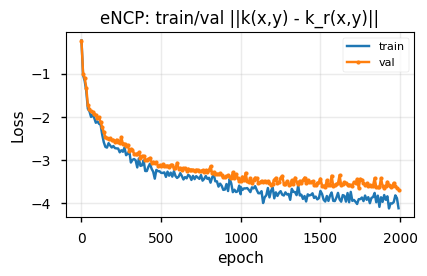

Training eNCP: 100%|█████████▉| 1992/2000 [05:14<00:01,  5.53it/s, loss=-4.09, val=-3.66]

Checkpoint saved to /home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_expectation_regression/checkpoints/encp_model.pth


Training eNCP: 100%|██████████| 2000/2000 [05:15<00:00,  6.33it/s, loss=-4.09, val=-3.66]



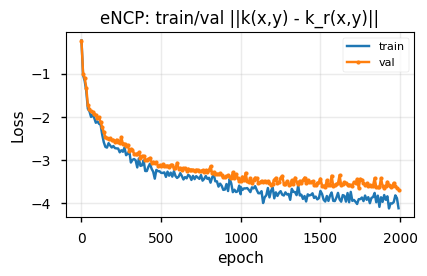

eNCP best val objective: -3.66245
eNCP model ready for inference


In [14]:
from symm_rep_learn.nn.equiv_layers import ResidualEncoder
from symm_rep_learn.models import ENCP
from symm_learning.models import IMLP
import escnn 

G = escnn.group.CyclicGroup(2) 
trivial_irrep = G.trivial_representation
reflection_irrep = G.irrep(1)
gspace = escnn.gspaces.no_base_space(G)

x_type = escnn.nn.FieldType(gspace, [reflection_irrep])
y_type = escnn.nn.FieldType(gspace, [trivial_irrep])

encp = ENCP(
    embedding_x=IMLP(
            in_type=x_type,
            out_dim=EMBEDDING_DIM,
            hidden_units=[EMBEDDING_DIM * 2] * 2,
            activation="ELU",
            bias=True,
    ),
    embedding_y=IMLP(
            in_type=y_type,
            out_dim=EMBEDDING_DIM,
            hidden_units=[EMBEDDING_DIM * 2] * 2,
            activation="ELU",
            bias=True,
    ),
    orth_reg=ORTH_REG,
    centering_reg=CENTERING_REG,
    momentum=MOMENTUM,
).to(DEVICE)
print(encp)

# Checkpoint path for eNCP
encp_checkpoint = CHECKPOINT_PATH / "encp_model.pth"

# Check if checkpoint exists
if checkpoint_exists(encp_checkpoint):
    print("Loading eNCP model from checkpoint...")
    encp_optimizer = torch.optim.Adam(encp.parameters(), lr=NCP_LR)
    best_val, last_epoch = load_checkpoint(encp, encp_optimizer, encp_checkpoint)
    print(f"eNCP loaded - best val objective: {best_val:.5f}")
    best_encp_state = encp.state_dict()
else:
    print("Training eNCP model from scratch...")
    best_val = float("inf")
    pat = 0
    best_encp_state = encp.state_dict()

    pbar = tqdm(range(2 * EPOCHS), desc="Training eNCP")
    plotter_encp = LiveLossPlotter(title=f"eNCP: train/val {VAL_METRIC}", plot_freq=PLOT_FREQ)

    encp_optimizer = torch.optim.Adam(encp.parameters(), lr=NCP_LR)

    for epoch in pbar:
        encp.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            encp_optimizer.zero_grad()
            fx, hy = encp(xb, yb)
            loss, metrics = encp.loss(fx, hy)
            loss.backward()
            encp_optimizer.step()

        if epoch % CHECK_EVERY == 0 or epoch == EPOCHS - 1:
            vm, val_metrics = val_objective(encp, val_dl)
            pbar.set_postfix(loss=float(loss.item()), val=vm)
            # live update at val check (forces redraw regardless of freq)
            plotter_encp.update(
                epoch, train_loss=float(metrics[VAL_METRIC]), val_loss=float(val_metrics[VAL_METRIC]), force=True
            )
            if vm < best_val:
                best_val = vm
                best_encp_state = encp.state_dict()
                pat = 0
                # Save checkpoint when we get a better validation score
                save_checkpoint(encp, encp_optimizer, best_val, epoch, encp_checkpoint)
            else:
                pat += 1
                if pat >= PATIENCE:
                    print(f"Early stopping eNCP at epoch {epoch}")
                    break

    plotter_encp.close()
    print(f"eNCP best val objective: {best_val:.5f}")

encp.eval()
print(f"eNCP model ready for inference")

## CCDF comparison at unimodal and bimodal x
We compare the predicted conditional CDF (NCP) against a numerically estimated ground truth CCDF (by sampling from the known generative process) and the marginal CDF, for two conditioning values: one in the unimodal region and one in the bimodal region.

## Visualize conditional expectation vs ground truth

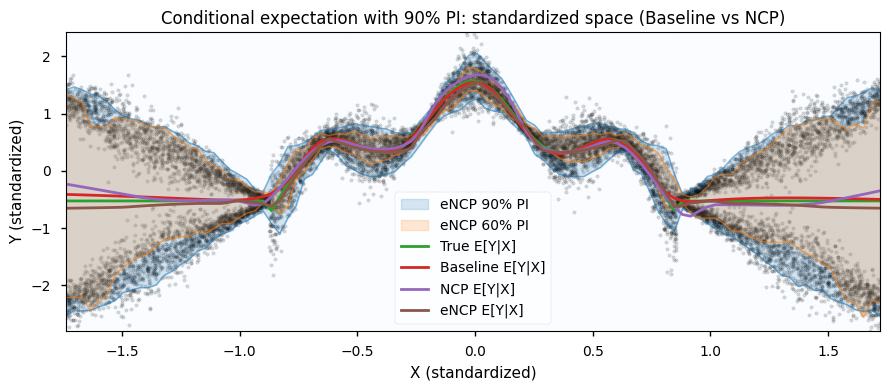

In [15]:
SEED = 42
ncp.eval()
encp.eval()
encp.load_state_dict(best_encp_state)

# Set seed
torch.manual_seed(SEED)
np.random.seed(SEED)
RIDGE_REG = 1e-2
# Fit the built-in linear decoder to map h(y) -> y (standardized)
dec_dl = DataLoader(TensorDataset(y_tr_c, y_tr_c), batch_size=BATCH_SIZE, shuffle=False)
ncp_lin_decoder = ncp.fit_linear_decoder(train_dataloader=dec_dl, ridge_reg=RIDGE_REG, lstsq=False)
encp_lin_decoder = encp.fit_linear_decoder(train_dataloader=dec_dl, ridge_reg=RIDGE_REG, lstsq=False)

# Build NCP Conditional CDF helper and 90% quantiles for y (support is in standardized y-space)
from plotting import plot_expectations_with_quantiles

from symm_rep_learn.inference.encp import ENCPConditionalCDF
from symm_rep_learn.inference.ncp import NCPConditionalCDF

discretization_kwargs = dict(random_state=int(SEED), subsample=None, u_eps=1e-5, output_distribution="normal")
ncp_ccdf = NCPConditionalCDF(
    model=ncp,
    y_train=y_tr_c,
    support_discretization_points=200,
    ridge_reg=RIDGE_REG,
    support_strategy="quantile_transformer",
    discretizer_kwargs=discretization_kwargs,
)
encp_ccdf = ENCPConditionalCDF(
    model=encp,
    y_train=y_type(y_tr_c),
    support_discretization_points=200,
    ridge_reg=RIDGE_REG,
    support_strategy="quantile_transformer",
    discretizer_kwargs=discretization_kwargs,
)

# Build dense grid on standardized x (do NOT use y support for x)
x_grid = torch.linspace(x_tr.min().item(), x_tr.max().item(), 100).reshape(-1, 1)
x_grid_c = (x_grid - x_mean) / x_std

with torch.no_grad():
    y_true_c = (true_condexp(x_grid) - y_mean) / y_std
    y_base_c = baseline_predict(x_grid_c)
    y_pred_ncp_c = ncp.conditional_expectation(x=x_grid_c.to(DEVICE), hy2zy=ncp_lin_decoder).cpu()
    y_pred_encp_c = encp.conditional_expectation(x=x_grid_c.to(DEVICE), hy2zy=encp_lin_decoder).cpu()
    # NCP 90% prediction interval (standardized y-space)

ncp_quantiles, encp_quantiles = {}, {}
for alpha in [0.10, 0.4]:
    q_lo_ncp, q_up_ncp = ncp_ccdf.conditional_quantiles(x_cond=x_grid_c, alpha=alpha)
    ncp_quantiles[alpha] = (q_lo_ncp, q_up_ncp)
    q_lo_encp, q_up_encp = encp_ccdf.conditional_quantiles(x_cond=x_grid_c, alpha=alpha)
    encp_quantiles[alpha] = (q_lo_encp, q_up_encp)

# Prepare inputs for the helper
expectations = {
    "True E[Y|X]": y_true_c.numpy().ravel(),
    "Baseline E[Y|X]": y_base_c.numpy().ravel(),
    "NCP E[Y|X]": y_pred_ncp_c.numpy().ravel(),
    "eNCP E[Y|X]": y_pred_encp_c.numpy().ravel(),
}
# est_quantiles = { f"NCP {(1-ALPHA)*100:.0f}% PI": (np.asarray(q_lo_ncp).ravel(), np.asarray(q_up_ncp).ravel()) }
est_quantiles = {}
# for alpha, (q_lo_ncp, q_up_ncp) in ncp_quantiles.items():
    # est_quantiles[f"NCP {(1 - alpha) * 100:.0f}% PI"] = (np.asarray(q_lo_ncp).ravel(), np.asarray(q_up_ncp).ravel())
for alpha, (q_lo_encp, q_up_encp) in encp_quantiles.items():
    est_quantiles[f"eNCP {(1 - alpha) * 100:.0f}% PI"] = (np.asarray(q_lo_encp).ravel(), np.asarray(q_up_encp).ravel())

fig, ax = plot_expectations_with_quantiles(
    x_train=x_tr_c.numpy().ravel(),
    y_train=y_tr_c.numpy().ravel(),
    x_grid=x_grid_c.numpy().ravel(),
    expectations=expectations,
    est_quantiles=est_quantiles,
    true_quantiles=None,
    figsize=(FIG_SIZE[0] * 3, FIG_SIZE[1] * 2),
)
# Overlay horizontal lines at discretized y-support (standardized space)
support_std = np.asarray(ncp_ccdf.discretized_support).squeeze().ravel()
xmin, xmax = float(np.min(x_grid_c.numpy())), float(np.max(x_grid_c.numpy()))
# ax.hlines(support_std, xmin, xmax, colors="lightgray", alpha=0.1, lw=0.4)

ax.set_title("Conditional expectation with 90% PI: standardized space (Baseline vs NCP)")
fig.tight_layout()
fig.savefig(PLOT_PATH / "condexp_full_comparison_with_quantiles.png", dpi=200)
plt.show()

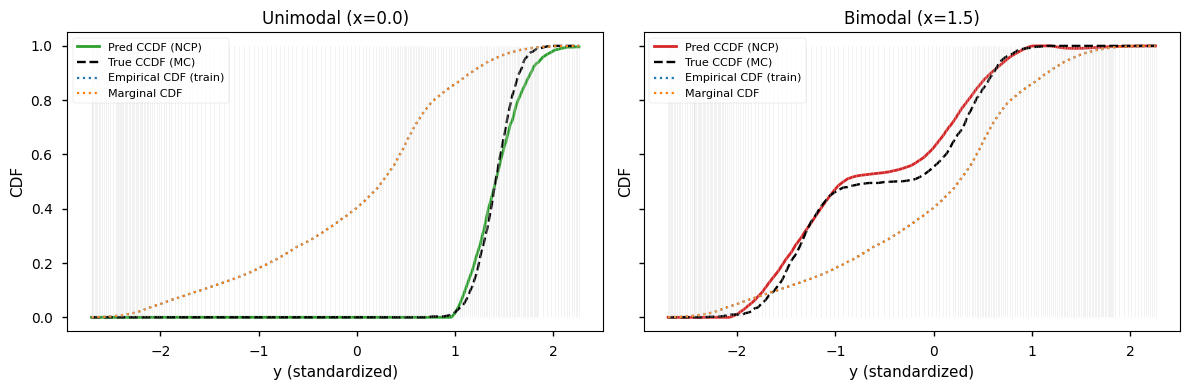

In [16]:
# Choose conditioning values: one unimodal (|x|<=1), one bimodal (1<|x|<=2)
x_vals = torch.tensor([0.1, 1.5], dtype=torch.float32).reshape(-1, 1)  # adjust as desired
labels = ["Unimodal (x=0.0)", "Bimodal (x=1.5)"]
colors = ["tab:green", "tab:red"]

# Support (standardized y-space) and model marginal CDF on that support
discretized_support = np.asarray(ncp_ccdf.discretized_support).squeeze().ravel()
model_marginal = np.asarray(ncp_ccdf.marginal_CDF).squeeze().ravel()

# Build empirical marginal CDF from training targets (standardized space)
y_all = y_tr_c.squeeze().cpu().numpy()
y_all_sorted = np.sort(y_all)

# Prepare predicted CCDFs and ground-truth CCDFs evaluated exactly on the support
ccdf_series = []
gt_series = []
for i, x0 in enumerate(x_vals):
    x0_c = ((x0 - x_mean) / x_std).to(DEVICE)
    ncp_pred = ncp_ccdf(x_cond=x0_c)
    ncp_pred = np.asarray(ncp_pred).squeeze().ravel()  # ensure 1D aligned with support
    ccdf_series.append(ncp_pred)

    # encp_pred = encp_ccdf(x_cond=x0_c)
    # encp_pred = np.asarray(encp_pred).squeeze().ravel()  # ensure 1D aligned with support
    # ccdf_series.append(encp_pred)

    # Ground-truth CCDF by sampling via make_dataset at fixed x, then standardize and evaluate at support
    _, y_samp = make_dataset(n=1000, seed=SEED + i, x=float(x0.item()))
    y_samp_c = ((y_samp - y_mean) / y_std).squeeze().cpu().numpy()
    y_samp_sorted = np.sort(y_samp_c)
    gt_cdf = np.searchsorted(y_samp_sorted, discretized_support, side="right") / len(y_samp_sorted)
    gt_series.append(gt_cdf)

# Plot per-x using the helper that respects support and adds vlines
fig, axs = plt.subplots(1, len(x_vals), figsize=(FIG_SIZE[0] * 4, FIG_SIZE[1] * 2), sharey=True)
axs = np.atleast_1d(axs)
for i, (c_pred, c_gt, lab, col) in enumerate(zip(ccdf_series, gt_series, labels, colors)):
    plot_conditional_cdf_on_support(
        discretized_support,
        c_pred,
        ax=axs[i],
        label_pred="Pred CCDF (NCP)",
        color_pred=col,
        y_train=y_tr_c,  # empirical marginal overlay
        model_marginal_cdf=model_marginal,  # model marginal overlay
        gt_ccdf=c_gt,
        label_gt="True CCDF (MC)",
        color_gt="black",
        ls_gt="--",
    )
    axs[i].set_title(lab)
    if i == 0:
        axs[i].set_ylabel("CDF")

fig.tight_layout()
fig.savefig(PLOT_PATH / "ccdf_unimodal_bimodal_compare.png", dpi=250)
plt.show()

## Metrics comparison: Baseline vs NCP

In [18]:
# 90% coverage evaluation for NCP on test set (standardized space)
@torch.no_grad()
def coverage_and_size_ncp(ccdf_model, dl, alpha):
    ccdf_model.eval()
    cov = 0.0
    size = 0.0
    n = 0
    for xb, yb in dl:
        q_lo, q_up = ccdf_model.conditional_quantiles(x_cond=xb, alpha=alpha)
        q_lo = torch.as_tensor(q_lo, dtype=torch.float32)
        q_up = torch.as_tensor(q_up, dtype=torch.float32)
        inside = ((q_lo <= yb) & (yb <= q_up)).float().mean()
        seg = (q_up - q_lo).abs().mean()
        cov += inside.item()
        size += seg.item()
        n += 1
    return cov / max(n, 1), size / max(n, 1)


# Collect results for table
import pandas as pd

results = []
for alpha in [0.10, 0.20, 0.30, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    cov_ncp, size_ncp = coverage_and_size_ncp(ncp_ccdf, test_dl, alpha)
    cov_encp, size_encp = coverage_and_size_ncp(encp_ccdf, test_dl, alpha)
    
    results.append({
        'Alpha': alpha,
        'Desired Coverage (%)': (1 - alpha) * 100,
        'NCP Coverage (%)': cov_ncp * 100,
        'eNCP Coverage (%)': cov_encp * 100,
        'NCP CI Size': size_ncp,
        'eNCP CI Size': size_encp,
        'NCP Coverage Error': abs(cov_ncp * 100 - (1 - alpha) * 100),
        'eNCP Coverage Error': abs(cov_encp * 100 - (1 - alpha) * 100)
    })

# Create DataFrame and display table
df_results = pd.DataFrame(results)

# Format the table for better display
pd.set_option('display.float_format', '{:.2f}'.format)
print("Coverage and Confidence Interval Size Results")
print("=" * 80)
print(df_results.to_string(index=False))

# Create a more detailed comparison table
print("\n\nDetailed Comparison Table")
print("=" * 80)
comparison_df = df_results[['Alpha', 'Desired Coverage (%)', 'NCP Coverage (%)', 'eNCP Coverage (%)', 
                           'NCP CI Size', 'eNCP CI Size']].copy()

print(comparison_df.to_string(index=False))

Coverage and Confidence Interval Size Results
 Alpha  Desired Coverage (%)  NCP Coverage (%)  eNCP Coverage (%)  NCP CI Size  eNCP CI Size  NCP Coverage Error  eNCP Coverage Error
  0.10                 90.00             92.72              91.04         1.58          1.46                2.72                 1.04
  0.20                 80.00             84.65              81.52         1.39          1.30                4.65                 1.52
  0.30                 70.00             75.02              71.59         1.24          1.17                5.02                 1.59
  0.40                 60.00             63.44              59.42         0.96          1.07                3.44                 0.58
  0.50                 50.00             52.21              48.39         0.60          0.55                2.21                 1.61
  0.60                 40.00             43.88              40.12         0.41          0.35                3.88                 0.12
  0.70          

KeyError: 'Size Ratio (eNCP/NCP)'

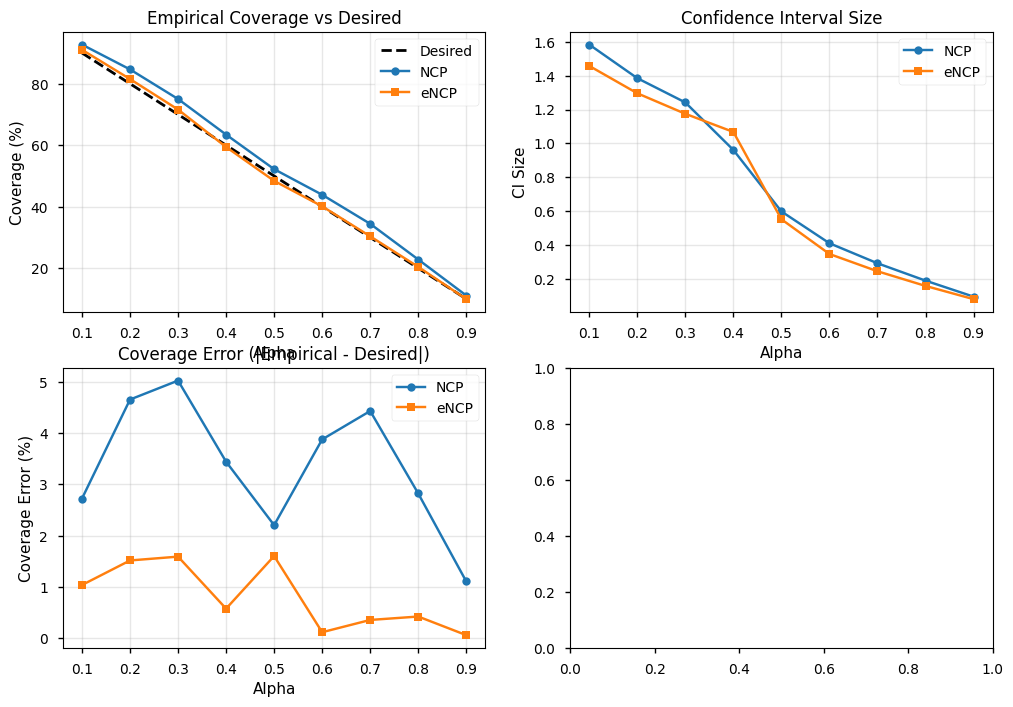

In [ ]:
# Visualize results in plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Coverage comparison
axes[0, 0].plot(df_results['Alpha'], df_results['Desired Coverage (%)'], 'k--', label='Desired', linewidth=2)
axes[0, 0].plot(df_results['Alpha'], df_results['NCP Coverage (%)'], 'o-', label='NCP', markersize=6)
axes[0, 0].plot(df_results['Alpha'], df_results['eNCP Coverage (%)'], 's-', label='eNCP', markersize=6)
axes[0, 0].set_xlabel('Alpha')
axes[0, 0].set_ylabel('Coverage (%)')
axes[0, 0].set_title('Empirical Coverage vs Desired')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# CI Size comparison
axes[0, 1].plot(df_results['Alpha'], df_results['NCP CI Size'], 'o-', label='NCP', markersize=6)
axes[0, 1].plot(df_results['Alpha'], df_results['eNCP CI Size'], 's-', label='eNCP', markersize=6)
axes[0, 1].set_xlabel('Alpha')
axes[0, 1].set_ylabel('CI Size')
axes[0, 1].set_title('Confidence Interval Size')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Coverage error
axes[1, 0].plot(df_results['Alpha'], df_results['NCP Coverage Error'], 'o-', label='NCP', markersize=6)
axes[1, 0].plot(df_results['Alpha'], df_results['eNCP Coverage Error'], 's-', label='eNCP', markersize=6)
axes[1, 0].set_xlabel('Alpha')
axes[1, 0].set_ylabel('Coverage Error (%)')
axes[1, 0].set_title('Coverage Error (|Empirical - Desired|)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Size ratio
axes[1, 1].axhline(y=1.0, color='k', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Alpha')
axes[1, 1].set_ylabel('Size Ratio (eNCP/NCP)')
axes[1, 1].set_title('Relative CI Size (eNCP vs NCP)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(PLOT_PATH / "coverage_and_size_comparison.png", dpi=200, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n\nSummary Statistics")
print("=" * 50)
print(f"Mean Coverage Error - NCP: {df_results['NCP Coverage Error'].mean():.2f}%")
print(f"Mean Coverage Error - eNCP: {df_results['eNCP Coverage Error'].mean():.2f}%")
print(f"Mean CI Size - NCP: {df_results['NCP CI Size'].mean():.3f}")
print(f"Mean CI Size - eNCP: {df_results['eNCP CI Size'].mean():.3f}")
print(f"Mean Size Ratio (eNCP/NCP): {comparison_df['Size Ratio (eNCP/NCP)'].mean():.3f}")

# Save results to CSV
csv_path = PLOT_PATH / "coverage_results.csv"
df_results.to_csv(csv_path, index=False)
print(f"\nResults saved to: {csv_path}")